# pycall.rb による Python データツールを用いたデータ解析

このノートブックでは、pycall.rb を通して Python データツールを用いたデータ解析を実演します。

Ruby では、機械学習や統計解析などを駆使した高度なデータサイエンスをするためのツールは揃っていませんが、pycall.rb を介して Python のデータツールを利用することでその穴を埋めることができます。本ノートブックは、Ruby から Python データツールを利用する方法と、そのメリット・デメリットを説明します。

## pycall.rb とは

pycall.rb は Ruby から Python インタープリタの機能を利用するためのライブラリです。pycall.rb のコア機能は、共有ライブラリ libpython で提供されている Python インタープリタの C API を利用して作られています。そして、Ruby から自然に Python の機能にアクセスするための型変換やプロトコル変換などをするための仕組みを持っています。

pycall.rb 単体でも Python のライブラリを利用できますが、ものによってはライブラリ特有の型変換を定義したり、Ruby 側にラッパークラスを用意したりする方が扱いやすくなる場合があります。現在、numpy、matplotlib、pandas の3つのライブラリに関しては、そのようなラッパー gem を提供しています。

## pycall.rb のインストール

### pycall.rb に必要な Python の実行環境

pycall.rb は共有ライブラリ libpython を利用します。そのため pycall.rb は、静的リンクされた Python と一緒に利用することはできません。

「IRuby インストールガイド」にしたがって IRuby の実行環境をインストールしている場合、pycall.rb を利用するために必要な Python の実行環境もインストールされています。お使いの環境に Python がインストールされていない場合や、インストール済みの Python がスタティックリンクされたものである場合は、「IRuby インストールガイド」を参照して libpython を含む Python をインストールしてください。

### pycall.rb および関連ライブラリのインストール

pycall.rb と関連するラッパー gem 群をインストールするには次のコマンドを実行してください。

```console
gem install pycall numpy matplotlib pandas
```

## pycall.rb で Python の機能を利用する方法

### pycall.rb をロードする

pycall.rb は `require 'pycall'` でロードします。

In [1]:
require 'pycall'

true

pycall.rb をロードしただけでは Python 環境は初期化されません。pycall.rb が Python 環境を必要としたタイミングで自動的に初期化が実行されるようになっています。Python 環境を初期化するタイミングをコントロールするには明示的に `PyCall.init` メソッドを呼び出します。

### 利用する Python を指定する

pycall.rb がデフォルトで使用する Python 環境は、`python` コマンドで実行される Python 環境です。これを変更する方法は3つ存在します。

1. 環境変数 `LIBPYTHON` に利用する Python 環境の `libpython` 共有ライブラリのフルパスを指定する
2. `PyCall.init` の引数に利用する Python 環境の `python` コマンドのフルパスを指定する
3. 環境変数 `PYTHON` に利用する Python 環境の `python` コマンドのフルパスを指定する

環境変数 `LIBPYTHON` の値が最優先で採用されます。`PyCall.init` の引数を指定した場合は、環境変数 `PYTHON` の値は使用されません。

### モジュールのインポート

Python のライブラリは、モジュールとしてインポートして利用します。pycall.rb では `PyCall.import_module` メソッドによって Python のモジュールをロードし、そのオブジェクトを取得できます。ためしに Python の `math` モジュールをインポートしてみましょう。

In [2]:
pymath = PyCall.import_module('math')

<module 'math' from '/usr/local/lib/python3.6/lib-dynload/math.cpython-36m-x86_64-linux-gnu.so'>

変数 `pymath` は、Python の `math` モジュールオブジェクトを指しています。

### オブジェクトの属性アクセス

Python オブジェクトの属性の値を取得するには、Python の場合と同様に `obj.属性名` の形式を利用します。したがって、`pymath.pi` は Python の `math` モジュールの `pi` 属性の値を取得します。これは円周率なので `3.141592653589793` になるはずです。やってみましょう。

In [3]:
pymath.pi

3.141592653589793

予想通りでしたね。

### Python から Ruby への暗黙的な型変換

ところで、`pymath.pi` で得られる値はどのクラスのインスタンスだと思いますか？調べてみましょう。

In [4]:
pymath.pi.class

Float

このとおり Float クラスのインスタンスでした。Python の `math.pi` は float 型の値です。pycall.rb は Python の float 型の値を Ruby 側に持ってくる際に、Float クラスのインスタンスに変換するのです。このような暗黙的な型変換には次のパターンが存在します。

| 変換前の Python の型 | 変換後の Ruby のクラス | 備考 |
|:---:|:---:|:--- |
| bool | TrueClass / FalseClass | |
| int | Integer | |
| long | Integer | Python 2.7 のみ |
| float | Float | |
| complex | Complex | |
| bytes | String | Python 2.7 では str と同じ |
| str | String | |
| unicode | String | Python 2.7 のみ |

上記の表で示した型変換では、Python 側のオブジェクトを保持せずに Ruby 側に対応するオブジェクトを作ります。

Python のオブジェクトを保持したまま Ruby 側で特定のクラスのオブジェクトを作る方式の型変換も存在します。

| 変換前の Python の型 | 変換後の Ruby のクラス |
|:---:|:---:|
| type | Class |
| module | Module |
| list | PyCall::List |
| tuple | PyCall::Tuple |
| dict | PyCall::Dict |
| slice | PyCall::Slice |
| set | PyCall::Set |

上記の表の中で、5つのクラス `PyCall::List`、`PyCall::Tuple`、`PyCall::Dict`、`PyCall::Slice`、`PyCall::Set`はモジュール `PyCall::PyObjectWrapper` を include しています。このモジュールは、Python オブジェクトをラップする全てのクラスが include するため、Python オブジェクトのラッパーオブジェクトであることを判定するためにこのモジュールを利用できます。

### Python の関数に Ruby の値を渡す

さて、続いては Python の `math.sin` 関数を使って次の等式を確認してみましょう。

$$\sin(30^{\circ}) = \cfrac{1}{2}$$

In [5]:
pymath.sin(30*Math::PI/180)

0.49999999999999994

だいたい $0.5$ が得られましたね。Ruby の `Math.sin` を使った場合も同じ結果になります。

In [6]:
Math.sin(30*Math::PI/180)

0.49999999999999994

このように、Python の関数に Ruby のオブジェクトを渡すことができます。

### Ruby から Python への暗黙的な型変換

Python の関数に Ruby のオブジェクトを渡すときも、暗黙的な型変換が働いています。

| 変換前の Ruby のクラス | 変換後の Python の型 | 備考 |
| --- | --- | --- |
| `NilClass` | `NoneType` | |
| `TrueClass` | `bool` | |
| `FalseClass` | `bool` | |
| `Integer` | `int` / `long` | 値の大きさによって型が決定される |
| `Float` | `float` | |
| `Rational` | `fractions.Fraction` | |
| `Complex` | `complex` | 実部と虚部は `float` に変換される |
| `String` | `str` / `unicode` / `bytes` | エンコーディングによって変換後の型が決定される |
| `Symbol` | `str` / `unicode` / `bytes` | エンコーディングによって変換後の型が決定される |
| `Array` | `list` | |
| `Hash` | `dict` | |
| `PyCall::PyObjectWrapper` | `object` | ラップしている Python オブジェクトがそのまま使用される |

### Python コードの実行

Ruby プログラム内に Python プログラムを埋め込んで実行する方法が2つあります。一つ目はメソッド `PyCall.eval` を使用する方法です。`PyCall.eval` は Python の**式**を評価します。もう一つはメソッド `PyCall.exec` を使用する方法です。`PyCall.exec` は Python の**文**を評価します。

Python の式には次の要素などが含まれます。

- リテラル
- 変数参照
- 算術演算
- 関数呼び出し

一方、以下の要素などは Python では文になります。

- 関数定義
- クラス定義

Python における式と文の違いについての詳細は、Python リファレンスマニュアルの次の項を参照してください。

- <https://docs.python.jp/3/reference/expressions.html>
- <https://docs.python.jp/3/reference/simple_stmts.html>

### 独自のラッパークラスを定義して型変換を登録する

Python の型オブジェクトとそのラッパークラスのペアについての型変換を登録するには、ラッパークラスのプライベートメソッド `register_python_type_mapping` を呼び出します。

例えば、`numpy.ndarray` 型に対するラッパークラスを `Numpy::NDArray` クラスとして定義し、型変換を登録するコードは次のようになります (これと同等の処理を numpy gem がやっています)。

```ruby
module Numpy
  NDArray = PyCall.import_module('numpy').ndarray
  class NDArray
    register_python_type_mapping
  end
end
```


### 自作の Python モジュールを import する

`PyCall.import_module` でインポートされるモジュールは、`PyCall.sys.path` で指定されたモジュール検索パスから探索されます。自作の Python モジュールをインポートするには、`PyCall.import_module` を呼び出す前にモジュールが配置されているディレクトリをメソッド　`append`　などで `PyCall.sys.path` に追加してください。

例えば、Ruby スクリプトファイルと同じディレクトリにある `foo.py` というファイルをインポートするには次のようにします。

```ruby
PyCall.sys.path.append(File.dirname(__FILE__))
foo = PyCall.import_module('foo')
```

## Ruby から Python データツールを利用したデータ解析をしてみよう

Ruby から Python のデータツールを使ってデータ解析をやってみましょう。解析対象のデータは、データ解析の入門でよく利用される Iris データセットです。

### 生データのダウンロード

データ解析の対象となる加工前のデータを生データ (raw data) と呼びます。Iris データセットの生データは下記の URL で配布されています。

<https://archive.ics.uci.edu/ml/datasets/iris>

このページの「Data Folder」というタイトルのリンク先にある [iris.data](https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data) というファイルが生データです。これをダウンロードします。

In [7]:
unless File.exist?('iris.data')
  system("curl -sfSLO https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")
end

### データの読み込み

続いて、pandas のラッパーライブラリをロードし、関数 `pandas.read_csv` に相当するモジュール関数 `Pandas.read_csv` でデータフレームを作ります。

In [8]:
require 'pandas' # pandas のラッパーライブラリをロード
iris = Pandas.read_csv('iris.data', names: %w[SepalLength SepalWidth PetalLength PetalWidth Species])
nil

データの先頭と末尾をそれぞれ表示して中身を確認します。

In [9]:
iris.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [10]:
iris.tail()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


データの要約統計量を確認します。

In [11]:
iris.describe()

,SepalLength,SepalWidth,PetalLength,PetalWidth
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


データ全体ではなく、Species カラムの値別に要約統計量を確認します。

In [12]:
iris.groupby('Species').describe().T

Species            Iris-setosa  Iris-versicolor  Iris-virginica
PetalLength count    50.000000        50.000000       50.000000
            mean      1.464000         4.260000        5.552000
            std       0.173511         0.469911        0.551895
            min       1.000000         3.000000        4.500000
            25%       1.400000         4.000000        5.100000
            50%       1.500000         4.350000        5.550000
            75%       1.575000         4.600000        5.875000
            max       1.900000         5.100000        6.900000
PetalWidth  count    50.000000        50.000000       50.000000
            mean      0.244000         1.326000        2.026000
            std       0.107210         0.197753        0.274650
            min       0.100000         1.000000        1.400000
            25%       0.200000         1.200000        1.800000
            50%       0.200000         1.300000        2.000000
            75%       0.300000         1.500000        2.300000
            max       0.600000         1.800000        2.500000
SepalLength count    50.000000        50.000000       50.000000
            mean      5.006000         5.936000        6.588000
            std       0.352490         0.516171        0.635880
            min       4.300000         4.900000        4.900000
            25%       4.800000         5.600000        6.225000
            50%       5.000000         5.900000        6.500000
            75%       5.200000         6.300000        6.900000
            max       5.800000         7.000000        7.900000
SepalWidth  count    50.000000        50.000000       50.000000
            mean      3.418000         2.770000        2.974000
            std       0.381024         0.313798        0.322497
            min       2.300000         2.000000        2.200000
            25%       3.125000         2.525000        2.800000
            50%       3.400000         2.800000        3.000000
            75%       3.675000         3.000000        3.175000
            max       4.400000         3.400000        3.800000

### 生データの可視化

前処理をする前に、生データを加工せずそのまま可視化してデータ全体の傾向を掴むことは、データ解析では必ず行われます。
ここでは、pair plot (散布図行列) と呼ばれる図を描いてデータ全体の傾向を見てみましょう。pair plot は、データの数値型のカラムの全ペアについて、異なるカラムのペアの場合は散布図を、同じカラムのペアの場合はヒストグラムや箱ひげ図などを描いたものです。

ここでは Python の seaborn ライブラリを pycall.rb 経由で利用します。seaborn は matplotlib を利用して図を描きます。matplotlib によって描かれた図を IRuby Notebook で描画するためには、matplotlib のラッパー gem が提供している機能を有効化する必要があります。その機能は `matplotlib/iruby` をロードしてメソッド `Matplotlib::IRuby.activate` を呼び出します。

In [13]:
require 'matplotlib/iruby'
Matplotlib::IRuby.activate

[:inline, "module://ruby.matplotlib.backend_inline"]

これで、コードセルを実行中に matplotlib で作られた図が自動的にノートブック上に埋め込まれるようになりました。

次に seaborn をインポートしましょう。seaborn は sns という短縮形を使って参照されることが多いので、ここでもその習慣に従いましょう。

In [14]:
sns = PyCall.import_module('seaborn')

<module 'seaborn' from '/usr/local/lib/python3.6/site-packages/seaborn/__init__.py'>

あとは seaborn の関数 `sns.pairplot` を以下のように呼び出して pair plot を描画するだけです。以下のコードセルで `sns.pairplot` に渡している引数は次の意味があります。

- `iris`: 描画対象のデータフレーム
- `hue: 'Species'`: `Species` カラムの値別に色を変える
- `markers: %w[o s D]`: 散布図のマーカーの形を `Species` の値別に指定
- `diag_kws: {bins: 25}`: 対角線に配置するヒストグラムの bin 数を25に設定 (キーワード引数 `diag_kws` は対角線に配置する図のパラメータを指定する)

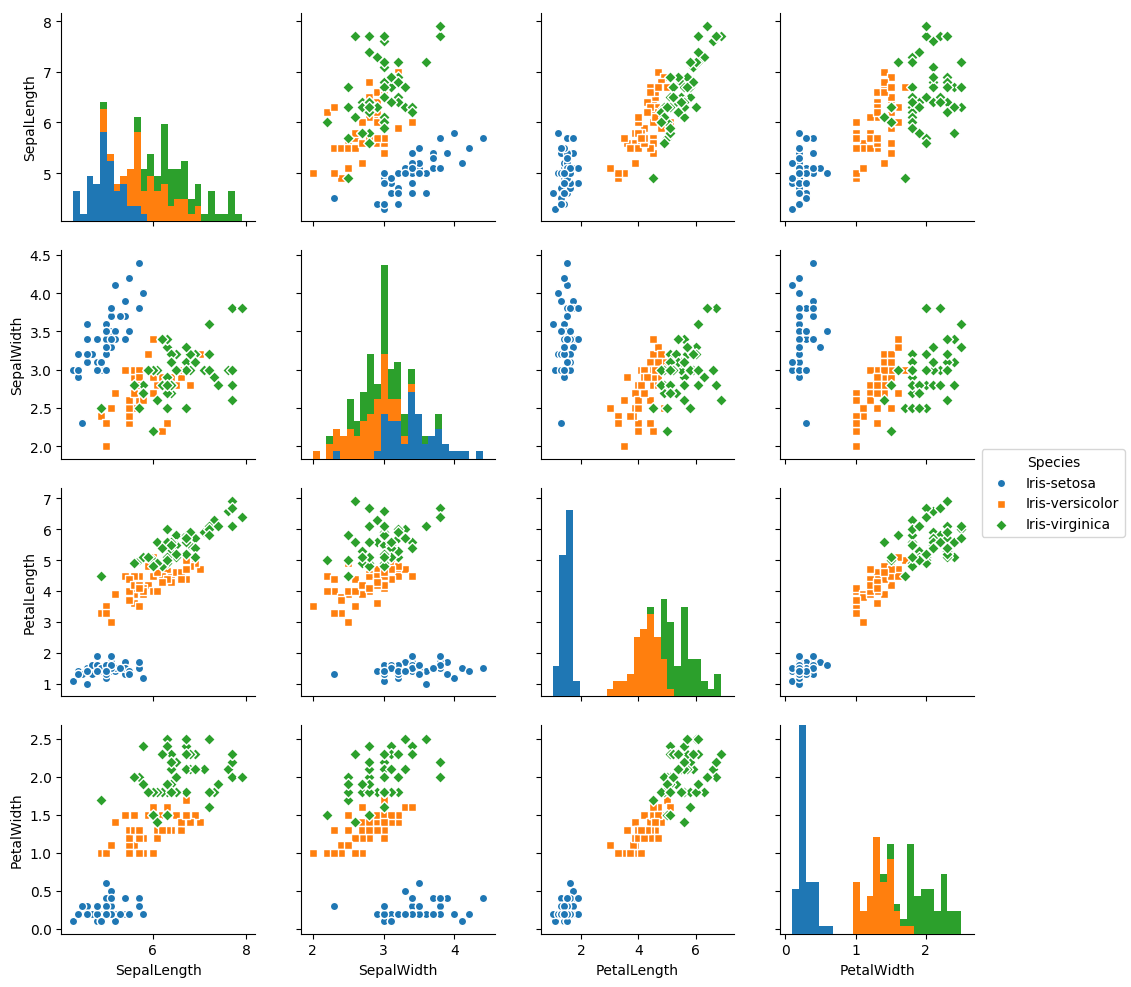

In [15]:
Matplotlib::Pyplot.ioff # インタラクティヴモードを OFF にすることで描画が高速になる
sns.pairplot(iris, hue: 'Species', markers: %w[o s D], diag_kws: {bins: 25})

### 簡単な探索的データ解析

この pair plot を見ると、次のことがわかります。

- `PetalLength` と `PetalWidth` の間に明らかな正相関がある
- `Iris-setosa` のサンプルだけ、他の2種から明確に離れて分布しています。
- `Iris-versicolor` のサンプルと `Iris-verginica` のサンプルは明確に分離していないが、何らかの条件で分離できそうではある

生データから新しい値を派生させて、種を見分ける特徴を探索してみましょう。

まず、ガク (sepal) の長さと幅の割合、花びら (petal) の長さと幅の割合をそれぞれ算出して、散布図を描いてみましょう。まずは、それぞれの比率の算出からです。

In [16]:
iris['SepalRatio'] = iris['SepalLength'] / iris['SepalWidth']
iris['PetalRatio'] = iris['PetalLength'] / iris['PetalWidth']

iris[['SepalRatio', 'PetalRatio', 'Species']].groupby('Species').describe.T

Species           Iris-setosa  Iris-versicolor  Iris-virginica
PetalRatio count    50.000000        50.000000       50.000000
           mean      7.078000         3.242837        2.780662
           std       3.123779         0.312456        0.407367
           min       2.666667         2.666667        2.125000
           25%       4.687500         3.016667        2.511364
           50%       7.000000         3.240385        2.666667
           75%       7.875000         3.417582        3.055556
           max      15.000000         4.100000        4.000000
SepalRatio count    50.000000        50.000000       50.000000
           mean      1.474578         2.160402        2.230453
           std       0.118693         0.228658        0.246992
           min       1.268293         1.764706        1.823529
           25%       1.394608         2.033929        2.031771
           50%       1.467708         2.161290        2.169540
           75%       1.547654         2.232692        2.342949
           max       1.956522         2.818182        2.961538

もう一度 pair plot を描いてみましょう。

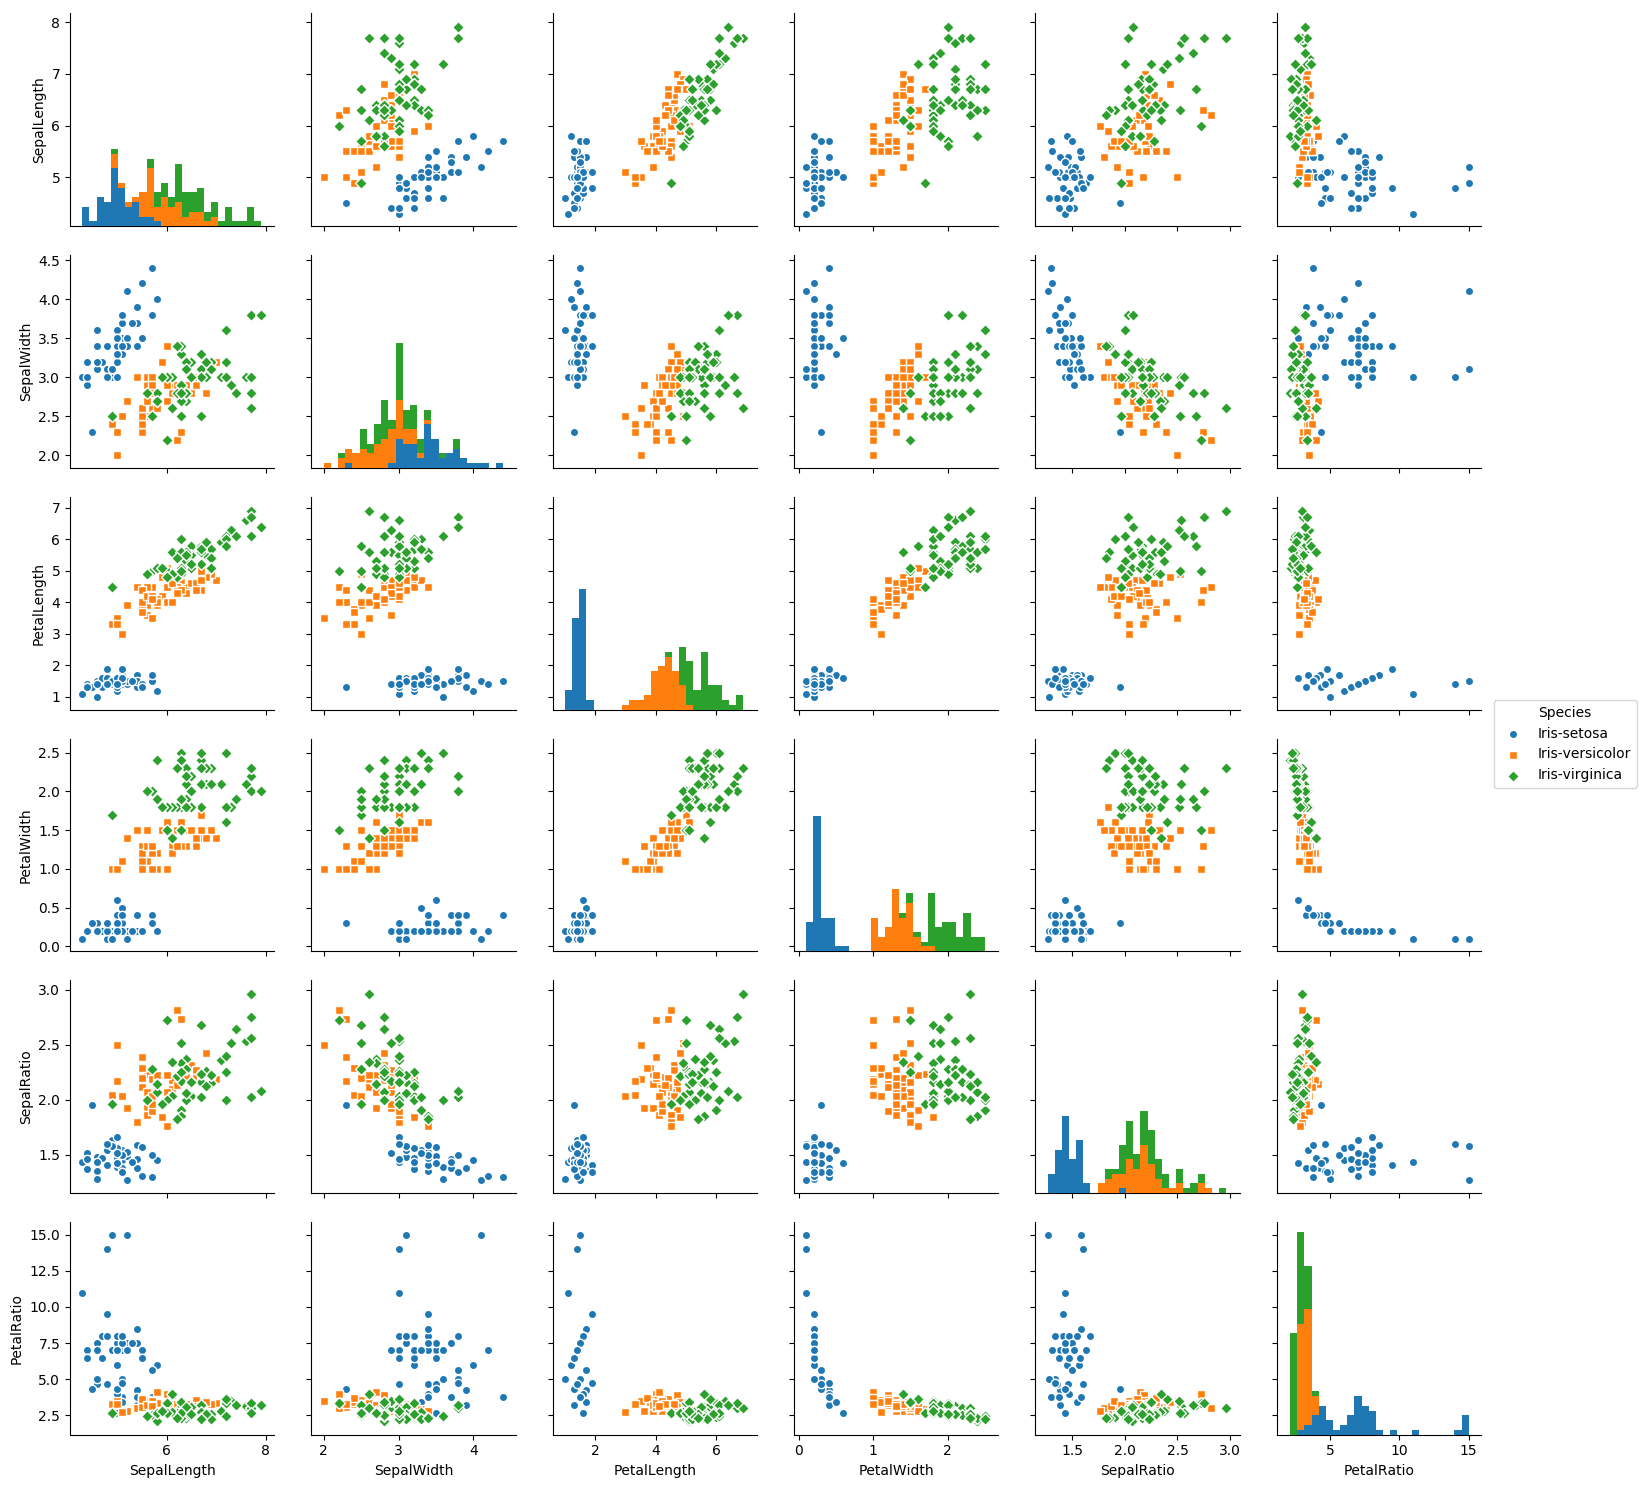

In [17]:
Matplotlib::Pyplot.ioff # インタラクティヴモードを OFF にすることで描画が高速になる
sns.pairplot(iris, hue: 'Species', markers: %w[o s D], diag_kws: {bins: 25})

ガクと花びらのアスペクト比を見ても、種ごとの特徴を明確に区別できそうにないですね。

### 主成分分析による特徴量の変換と次元削減

生データを主成分分析 (PCA) し、データの特徴の表現力が高い成分を導出し、その成分を利用してサンプルの分布を見てみましょう。

PCA の計算は　scikit-learn のモデルクラス `sklearn.decomposition.PCA` を用いて行います。まずはクラスをロードしましょう。

In [18]:
PCA = PyCall.import_module('sklearn.decomposition').PCA

<class 'sklearn.decomposition.pca.PCA'>

続いて、このクラスのインスタンスを作り、インスタンスメソッド `fit_transform` にデータを渡して、PCA による変換結果を受け取ります。

In [19]:
pca = PCA.new
x_trans = pca.fit_transform(iris.iloc[0..-1, 0..3])
nil

変数 `x_trans` には PCA による変換後の値が行列形式で入っています。行方向がサンプルで、列方向が特徴量です。特徴量の次元は、データの特徴の表現力 (固有値) が高い順に並んでいます。

`x_trans` の値を特徴量とする新しいデータフレームを作り、変数 `iris_trans` に入れましょう。

In [20]:
iris_trans = Pandas::DataFrame.new(data: x_trans, columns: %w[X0 X1 X2 X3])
iris_trans['Species'] = iris['Species']
nil

そして、`iris_trasn` についての pair plot を描いてみます。

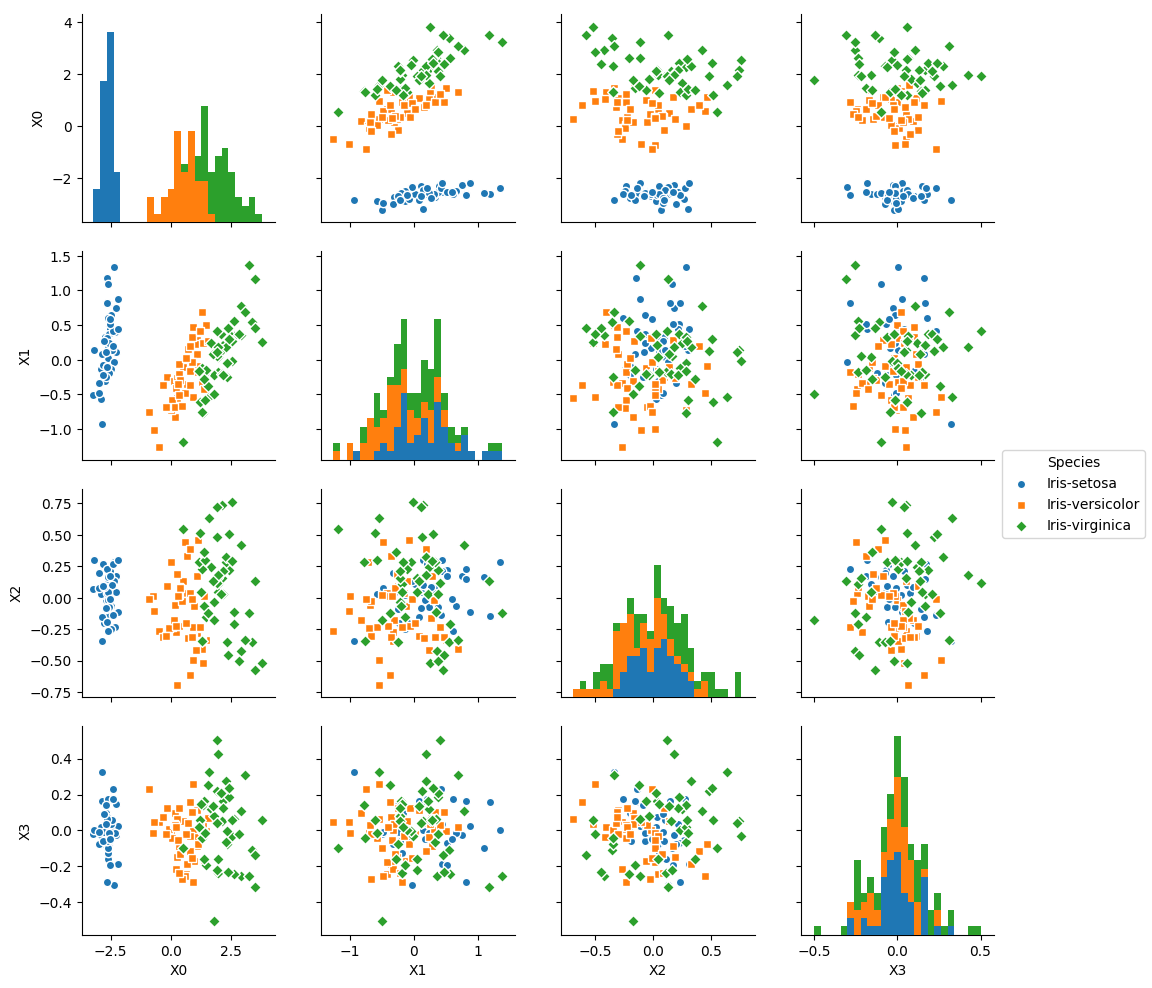

In [21]:
Matplotlib::Pyplot.ioff # インタラクティヴモードを OFF にすることで描画が高速になる
sns.pairplot(iris_trans, hue: 'Species', markers: %w[o s D], diag_kws: {bins: 25})

この pair plot を見ると、`Iris-versicolor` と `Iris-virginica` を明確に分離することはできそうにないことがわかります。

最後に `X0`, `X1`, `X2` の3次元でのデータの分布もみてみましょう。matplotlib には3次元散布図を描く機能があり、それを利用すると簡単に可視化できます。

まず、`Species` カラムの値を matplotlib のカラーコードに変換します。matplotlib は `C0`, `C1`, ... という形式でパレットの色番号でプロットマーカーの色を指定できます。この仕組みを利用するため、scikit-learn の `sklearn.preprocessing.LabelEncoder` を使って `Species` の値を連番に変換し、そこからさらに頭文字 `C` を付与することで色番号形式のカラーコードに変換します。

In [22]:
LabelEncoder = PyCall.import_module('sklearn.preprocessing').LabelEncoder
species_id = LabelEncoder.new.fit_transform(iris_trans['Species'])
colors = species_id.tolist.map {|cid| "C#{cid}" }

["C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C0", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C1", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2", "C2"]

色指定用の配列が作れたので、あとは 3D 散布図を描くだけです。3D 散布図を描くためには `matplotlib/axes_3d` をロードします。これは、`mpl_toolkits.mplot3d.axes_3d` をインポートし、さらに Ruby から利用するために必要な型変換の登録などの準備をするラッパーライブラリです。

このライブラリを読み込んだあとは、`Matplotlib::Pyplot.figure` で図オブジェクトを生成し、メソッド `gca` に `projection: '3d'` を指定して3次元プロット用の Axes オブジェクトを取得します。あとは、得られた Axes オブジェクトのメソッド `scatter` にデータを渡せば図が表示されます。以下のコードは、さらに軸ラベルや図のタイトルを設定し、3次元プロットを見る方向を調整しています。

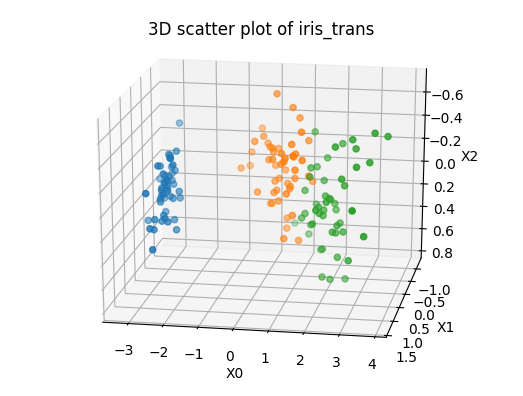

In [23]:
require 'matplotlib/axes_3d'
fig = Matplotlib::Pyplot.figure()
ax = fig.gca(projection: '3d')
ax.scatter(iris_trans['X0'], iris_trans['X1'], iris_trans['X2'], c: colors)
ax.set_xlabel("X0")
ax.set_ylabel("X1")
ax.set_zlabel("X2")
ax.set_title("3D scatter plot of iris_trans")
ax.view_init(200, 260)

### 機械学習で分類モデルを作成する

続いての例は機械学習です。ここでは教師あり学習の一種である分類モデルを作成します。その前に、教師あり学習について簡単におさらいしましょう。

#### 教師あり学習について

機械学習において、分類モデルは教師あり機械学習の一種です。「教師あり」という名称は、分類の正解データが与えられることから来ています。学習で作成された分類モデルは、ほとんどの場合が未知データ (学習で使用していないデータ) に対する分類結果の予測のために使用されます。

#### モデルの良し悪しと過学習

学習済みモデルの良し悪しを測るには、正解がわかっているデータをモデルに与えて、どのくらいの割合で正解するかを調べます。正当数、誤答数、全体のサンプル数などの数値の関係から、正解率 (precision)、再現率 (recall)、F1スコア (F1-score)、AUC などの尺度を求めることができます。モデルの良し悪しは、そのモデルを利用する用途に合わせて適切な尺度を利用して判定します。

学習済みモデルが、学習で使用したデータに対して100%に近い正解率を示す状態は、モデルがデータに対してうまく学習できているように思えますが、ほとんどの場合は過学習と呼ばれる状態になっています。現実のデータには確実にノイズが含まれており、全データに対して完璧に答えられるモデルはノイズに騙されていると考えられるのです。

#### モデルの検証による過学習の検出

学習済みモデルが過学習状態かどうかを確実に判定するには、学習で使用していないデータを利用してモデルの成績を確認する必要があります。
そのためには、学習で使用できるデータを訓練データ (training data) とテストデータ (test data) の2つに分け、モデルの学習では訓練データを使用し、モデルの成績評価ではテストデータを利用します。

#### iris データセットの種分類モデルの作成

`Species` カラムの値を予測する分類モデルを、Support Vector Machine (SVM) というアルゴリズムを利用して作ります。分類用の SVM モデルの実装として scikit-learn の `sklearn.svm.SVC` を利用します。

まず、PCA で変換済みの全データを訓練データとテストデータに分けます。この処理には関数 `sklearn.model_selection.train_test_split` が利用できます。次のコードは、この関数を利用して訓練データ (`x_train`, `y_train`) とテストデータ (`x_test`, `y_test`) を、テストデータのサイズが全体の4割になるように調整して作成します。

In [24]:
ModelSelection = PyCall.import_module('sklearn.model_selection')
x_train, x_test, y_train, y_test = ModelSelection.train_test_split(
  iris_trans.iloc[0..-1, 0..3], iris_trans['Species'],
  test_size: 0.4,
  random_state: 0
)
nil

そして、モデルクラス `sklearn.svm.SVC` を使用し、メソッド `fit` に訓練データを与えてモデルを学習し、メソッド `score` にテストデータを与えて成績を評価します。

In [25]:
SVC = PyCall.import_module('sklearn.svm').SVC
model = SVC.new

model.fit(x_train, y_train)
model.score(x_test, y_test)

0.94999999999999996

正解率 $95\%$ です。未知のデータに対し非常に正確に分類できるモデルができました。

## まとめ

本ノートブックでは、pycall.rb を紹介し、pycall.rb を介して Python のデータツールを利用してデータ解析を行いました。